# Protein embeddings improve phage-host interaction prediction

**Mark Edward M. Gonzales<sup>1, 2</sup>, Jennifer C. Ureta<sup>1, 2</sup> & Anish M.S. Shrestha<sup>1, 2</sup>**

<sup>1</sup> Bioinformatics Laboratory, Advanced Research Institute for Informatics, Computing and Networking, De La Salle University, Manila, Philippines <br>
<sup>2</sup> Department of Software Technology, College of Computer Studies, De La Salle University, Manila, Philippines 

{mark_gonzales, jennifer.ureta, anish.shrestha}@dlsu.edu.ph

<hr>

## Part I: Preliminaries

Import the necessary libraries and modules.

In [29]:
import os
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ConstantsUtil import ConstantsUtil

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
constants = ConstantsUtil()

<hr>

## Part II: RBP Length Distribution

In [31]:
with open(f'{constants.TEMP_PREPROCESSING}/{constants.RBP_LENGTHS}','rb') as rbp_lengths_file:
    lengths = pickle.load(rbp_lengths_file)

Q1 = np.percentile(lengths, 25, interpolation = 'midpoint')
Q3 = np.percentile(lengths, 75, interpolation = 'midpoint')
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

Lower bound: -533.0
Upper bound: 1587.0


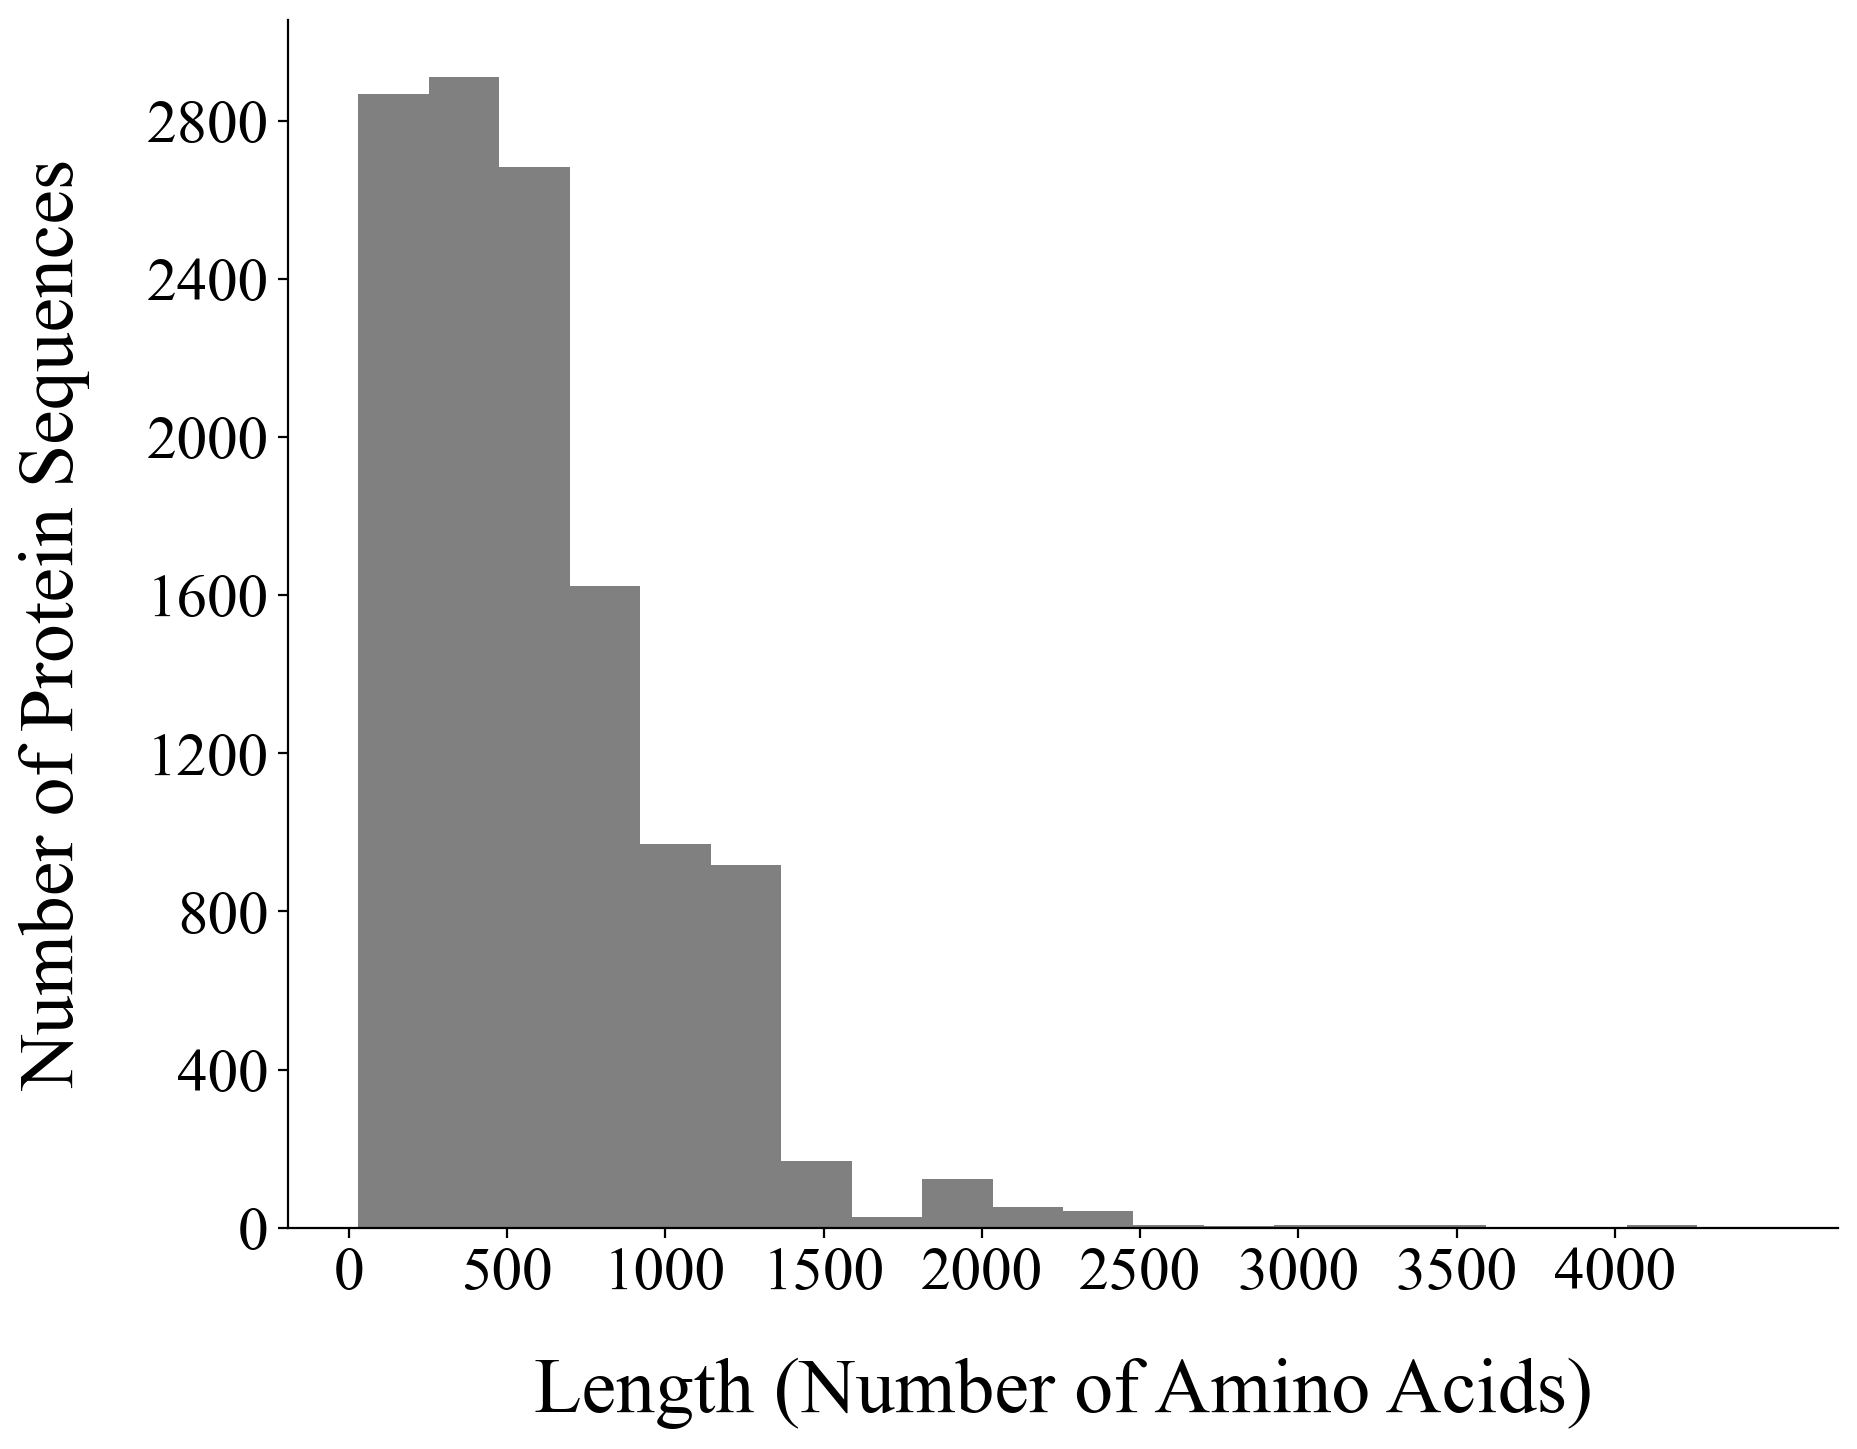

In [82]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 22

fig, ax = plt.subplots(figsize=(10,8), dpi=200)
plt.hist(lengths, bins = 20, color = 'gray')
plt.yticks(np.arange(0, 3200, 400))
plt.xticks(np.arange(0, 4500, 500))
plt.xlabel('Length (Number of Amino Acids)', labelpad = 20, fontsize = 28)
plt.ylabel('Number of Protein Sequences', labelpad = 20, fontsize = 28)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.show()

In [34]:
lengths_no_outliers = []
for length in lengths:
    if length <= upper_bound:
        lengths_no_outliers.append(length)

In [95]:
len(lengths_no_outliers)

12142

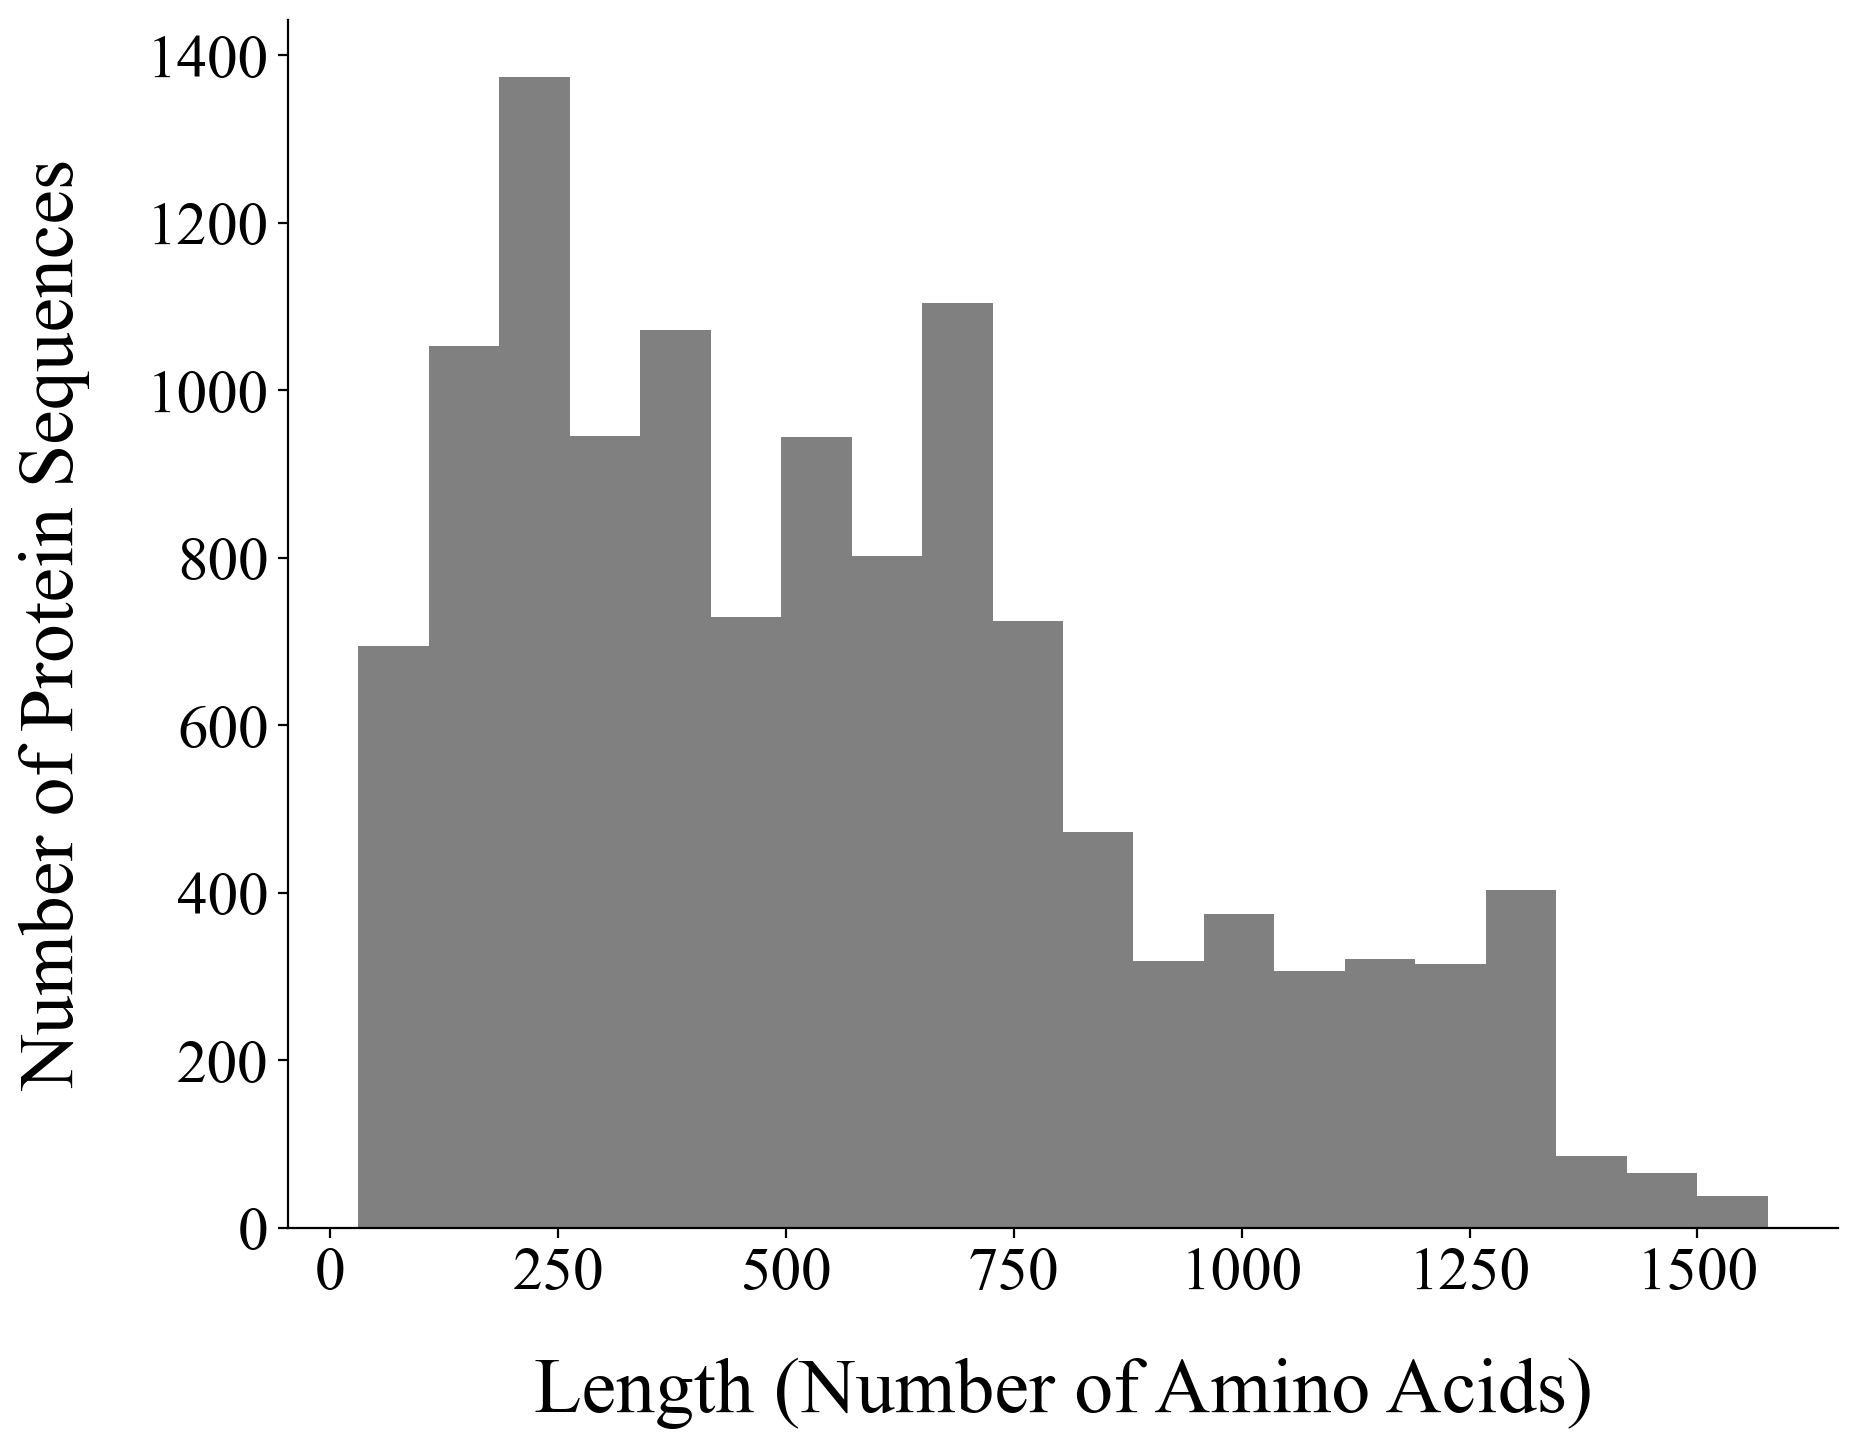

In [83]:
fig, ax = plt.subplots(figsize=(10,8), dpi=200)
plt.hist(lengths_no_outliers, bins = 20, color = 'gray')
plt.yticks(np.arange(0, 1600, 200))
plt.xticks(np.arange(0, 1750, 250))
plt.xlabel('Length (Number of Amino Acids)', labelpad = 20, fontsize = 28)
plt.ylabel('Number of Protein Sequences', labelpad = 20, fontsize = 28)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.show()

In [89]:
rbps = pd.read_csv(f'{constants.INPHARED}/{constants.DATA}/{constants.PLM_EMBEDDINGS_CSV["PROTT5"]}')

all_lengths = []
for x in rbps['Protein Sequence']:
    all_lengths.append(len(x))

C:\Users\Edward\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3331: DtypeWarning: Columns (13,31) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


0    MHQNISKENRGNYNNGIRPRIFMITTIDFRDIQAACIKQLDDMSKD...
1    MRIFYIHHPFLATHRYLLSNAYSTPYTDSITKLTTSYSSMPIILSV...
2    MLTDVDIQALIDASISGLSGEMPIVANIAARNALSLTKNTQVLVLD...
3    MFGVFIVRREGGYIGTQPNWDAANRPGNWDILDVYNRQRRNLWIQS...
4    MVNYRYRLSRLLIPGGIPDPEIGEVELFLASDRQGYINNIDLPPDP...
Name: Protein Sequence, dtype: object

In [96]:
len(all_lengths)

24752

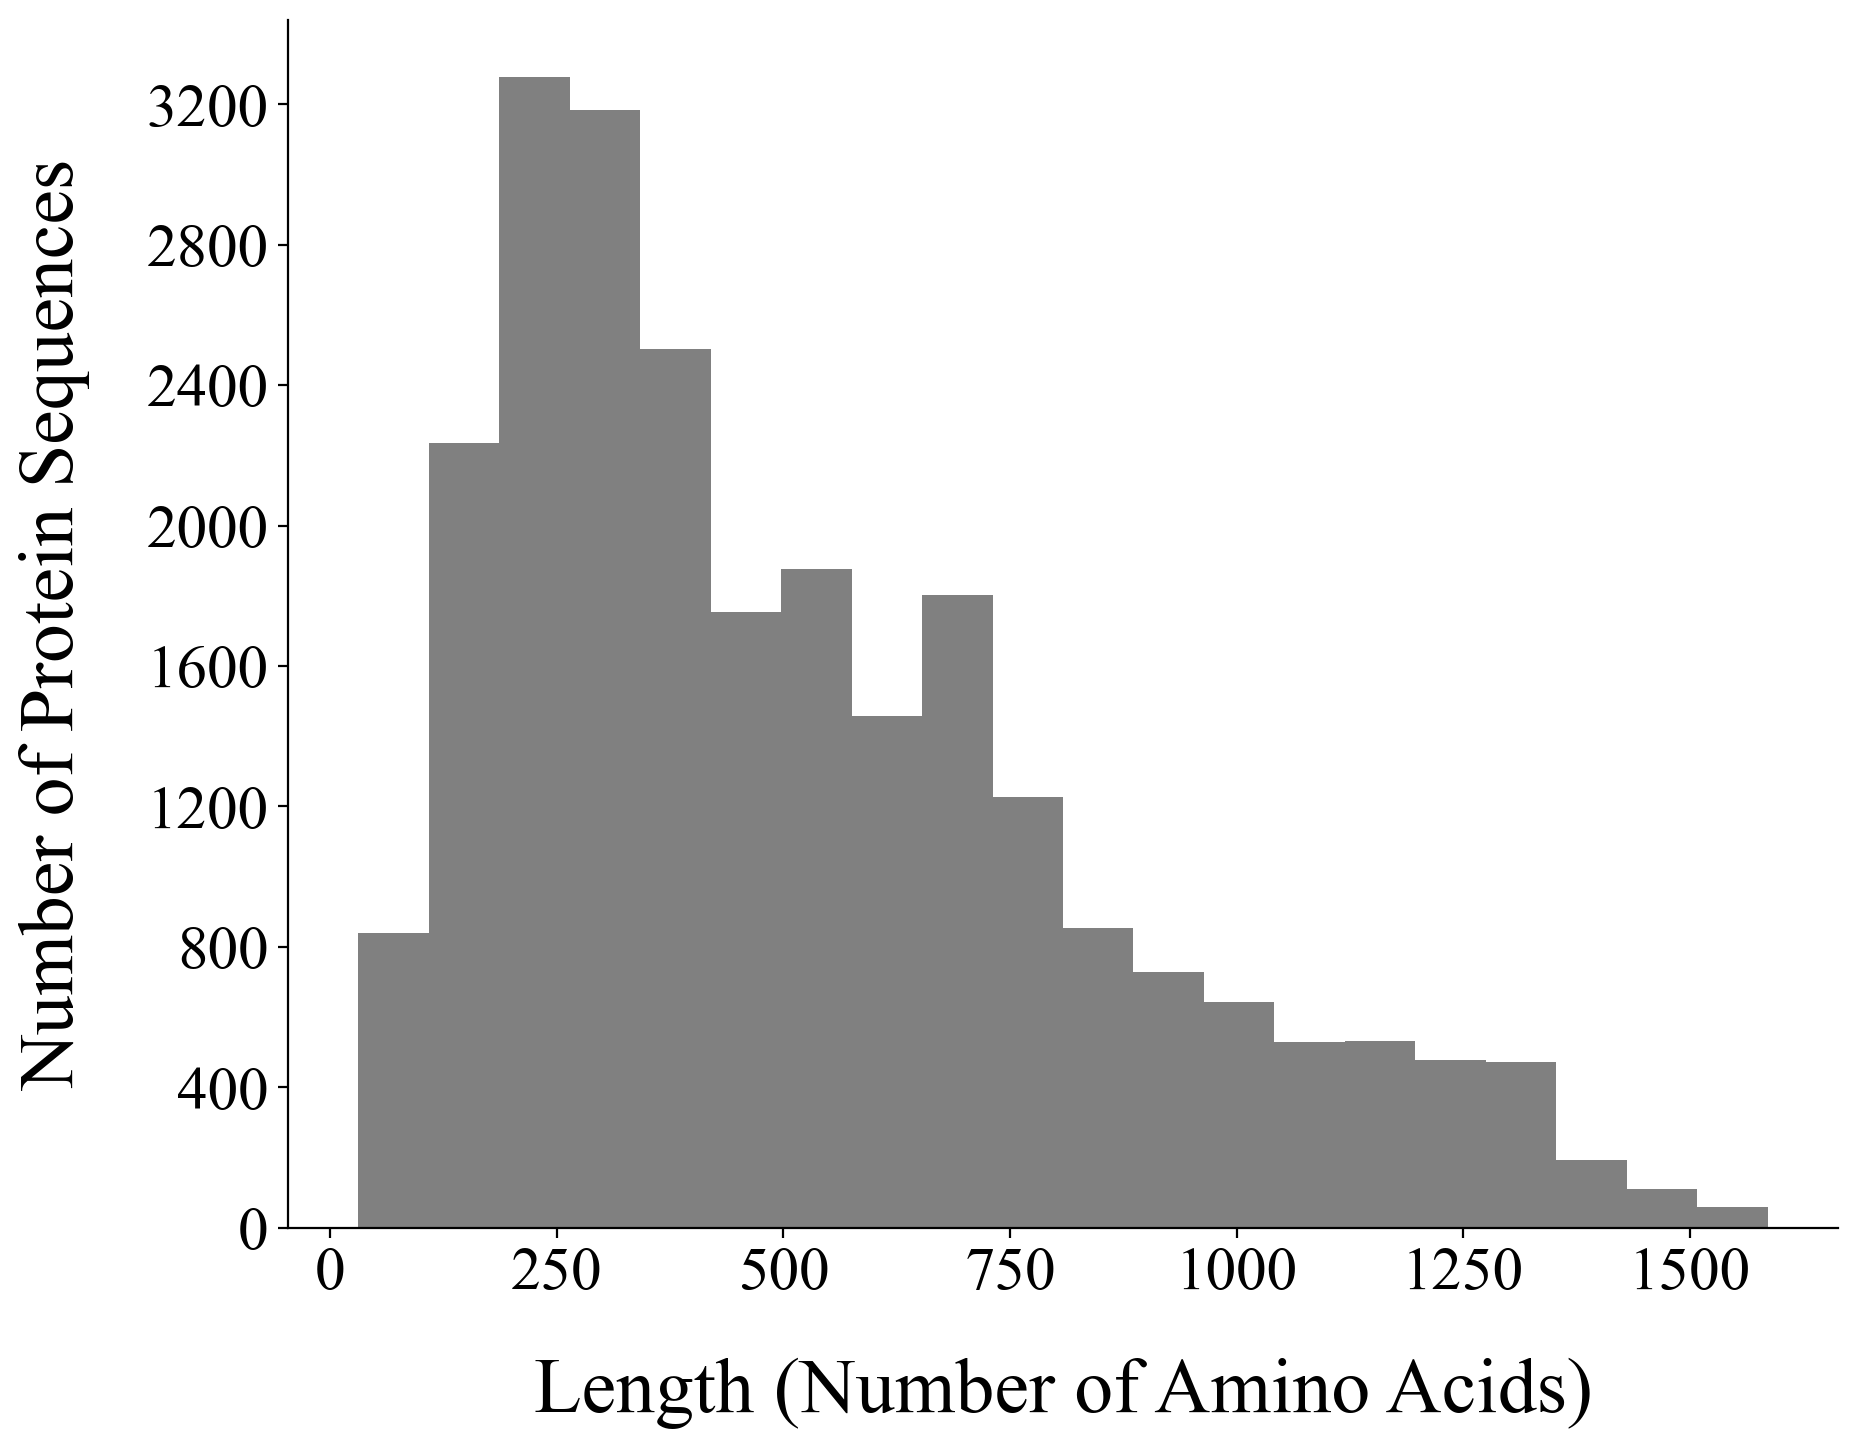

In [100]:
fig, ax = plt.subplots(figsize=(10,8), dpi=200)
plt.hist(all_lengths, bins = 20, color = 'gray')
plt.yticks(np.arange(0, 3600, 400))
plt.xticks(np.arange(0, 1750, 250))
plt.xlabel('Length (Number of Amino Acids)', labelpad = 20, fontsize = 28)
plt.ylabel('Number of Protein Sequences', labelpad = 20, fontsize = 28)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.show()

<hr>

## Part III: Statistics on Counts